In [154]:
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesResampler

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import ast

##### Reading DF from .csv

In [155]:
daily_stats = pd.read_csv('../daily_stats_user.csv', lineterminator='\n', index_col=0)

#### Converting str time series into array

In [156]:
daily_stats['success_ts'] = daily_stats.success_ts.apply(ast.literal_eval)

In [157]:
X_bot = []
X_nonbot = []

for row in daily_stats.itertuples():
    if row.bot == 1:
        X_bot.append(np.array(row.success_ts)) 
    elif row.bot == 0:
        X_nonbot.append(np.array(row.success_ts))

X_nonbot = np.array(X_nonbot)

X_bot = np.array(X_bot)

X = np.concatenate((X_bot, X_nonbot))

### Linear trend

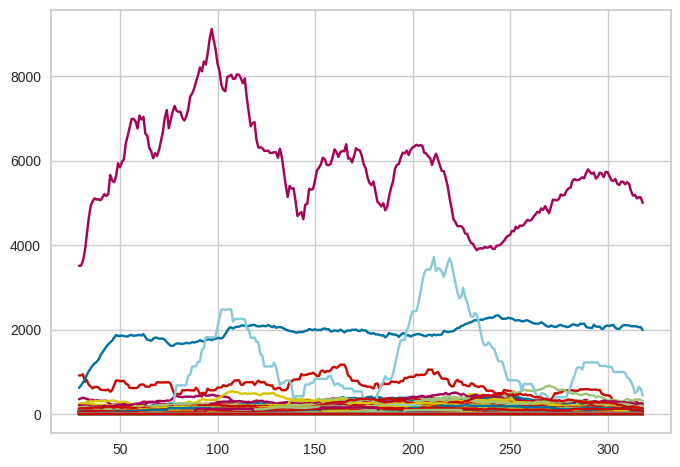

In [158]:
for x in daily_stats['success_ts']:
    plt.plot(pd.Series(x).rolling(window=30).mean())
plt.savefig('LinearTrend.png')
plt.show()

### Noise

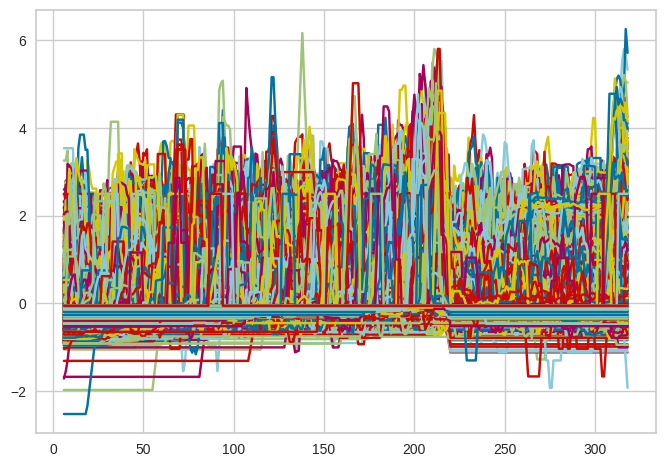

In [159]:
w = 7
for x in daily_stats['success_ts']:
    ts = pd.Series(x)
    plt.plot(((ts - ts.mean())/ts.std()).rolling(window=w).mean())
plt.savefig('Noise.png')
plt.show()

#### Distortion correction for euclidean distance

In [160]:
X_mean_nonbot = X_nonbot.copy()
for i in range(X_nonbot.shape[0]):
    X_mean_nonbot[i] = (X_nonbot[i] - X_nonbot[i].mean())/X_nonbot[i].std()

X_mean_bot = X_bot.copy()
for i in range(X_bot.shape[0]):
    X_mean_bot[i] = (X_bot[i] - X_bot[i].mean())/X_bot[i].std()

X = np.concatenate((X_mean_bot, X_mean_nonbot))

#### Finding K for all the users

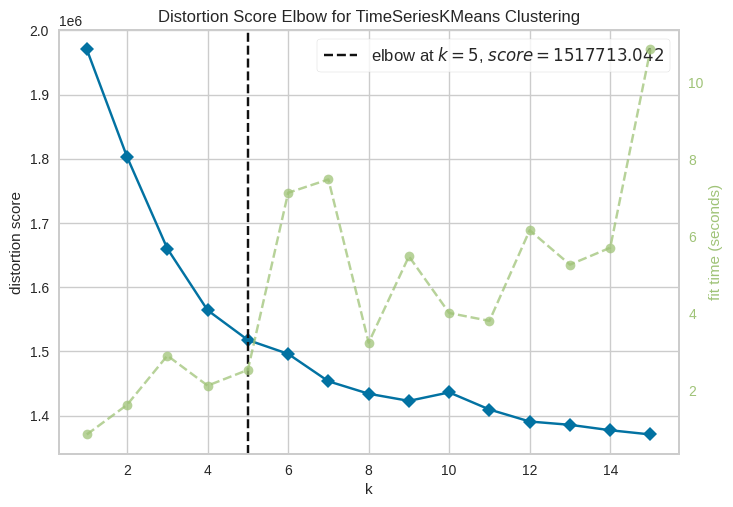

<AxesSubplot: title={'center': 'Distortion Score Elbow for TimeSeriesKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [161]:
model = TimeSeriesKMeans()
visualizer_people = KElbowVisualizer(model, k=(1,16))
visualizer_people.fit(X) # Fit the data to the visualizer
visualizer_people.show()  

#### Clustering all users

In [162]:
km = TimeSeriesKMeans(n_clusters=6, metric="euclidean", max_iter=10, random_state=0)
#X = TimeSeriesScalerMinMax(value_range=(0., 1.)).fit_transform(X)
km.fit(X)

TimeSeriesKMeans(max_iter=10, n_clusters=6, random_state=0)

#### Plotting cluster centroids

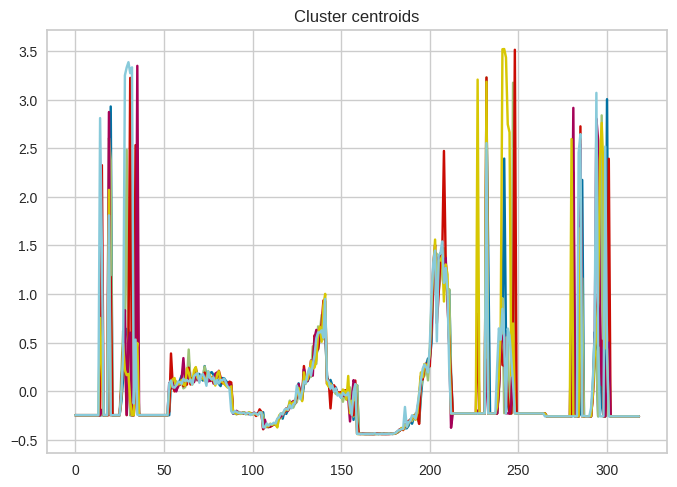

In [163]:
plt.plot(km.cluster_centers_.reshape(X.shape[1], 6))
plt.title('Cluster centroids')
plt.savefig('ClustersCentroids.png')
plt.show()

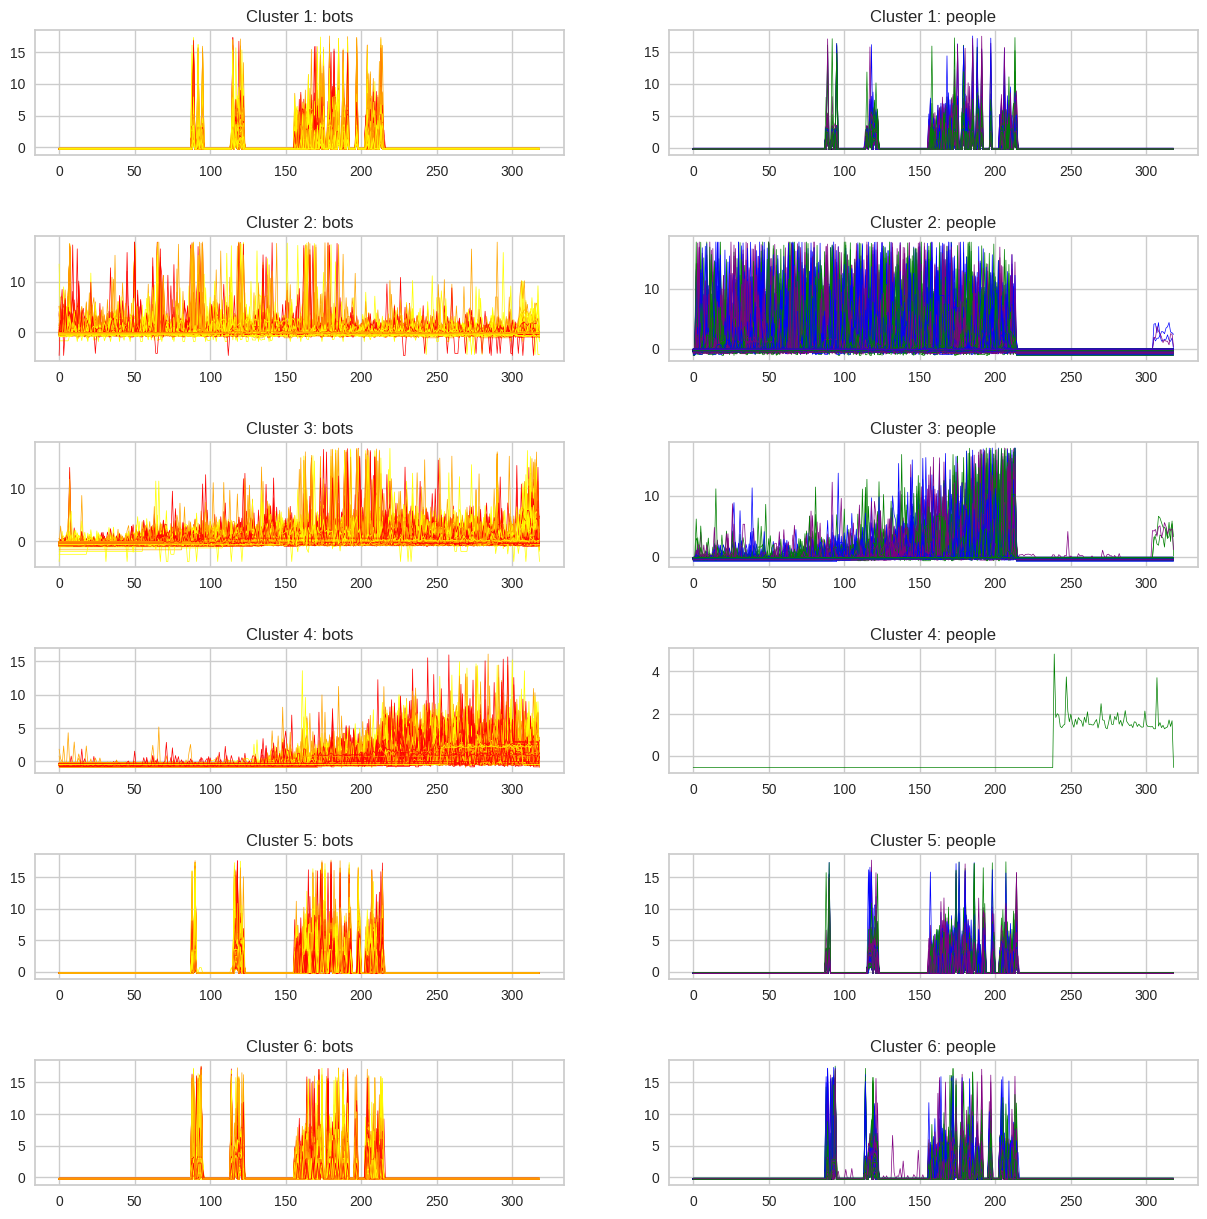

In [164]:
unique, counts = np.unique(km.labels_, return_counts=True)
plot_dict = {}
for j in range(len(counts)):
    plot_dict[j] = {'bot': [], 'nonbot':[]}
    for i,elem in enumerate(km.labels_):
        if elem == j:
            if X[i] in X_mean_bot:
                plot_dict[j]['bot'].append(X[i])
            elif X[i] in X_mean_nonbot:
                plot_dict[j]['nonbot'].append(X[i])
            else:
                print('aaa')

fig, axs = plt.subplots(len(plot_dict.keys()), 2, figsize=(15,15))
row = 0
botcol = ['orange', 'yellow', 'red']
pplcol = ['green', 'blue', 'purple']

for group, members in plot_dict.items():
    
    axs[row, 0].set_title("Cluster "+ str(row+1) + ": bots")
    for element in members['bot']:
        axs[row, 0].plot(element, linewidth=0.5, color=random.choice(botcol))

    axs[row, 1].set_title("Cluster "+ str(row+1) + ": people")
    for element in members['nonbot']:
        axs[row, 1].plot(element, linewidth=0.5, color=random.choice(pplcol))
    row += 1

fig.subplots_adjust(hspace=0.65)
fig.savefig('Clusters.png')
#plt.show()

#### Finding K for people

In [165]:
model = TimeSeriesKMeans()

In [166]:
visualizer_people = KElbowVisualizer(model, k=(1,16))

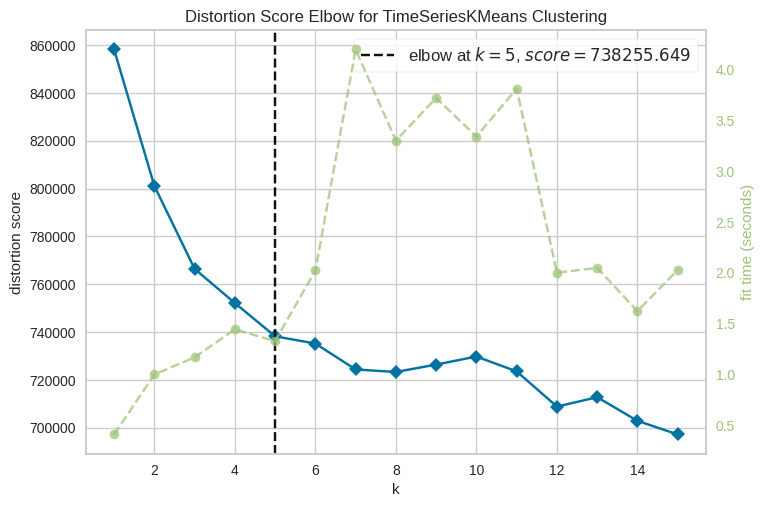

<AxesSubplot: title={'center': 'Distortion Score Elbow for TimeSeriesKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [167]:
visualizer_people.fit(X_mean_nonbot) # Fit the data to the visualizer
visualizer_people.show()  

#### Clustering people

In [168]:
km_nonbots = TimeSeriesKMeans(n_clusters=4, metric="euclidean", max_iter=10, random_state=0)
km_nonbots.fit(X_mean_nonbot)

TimeSeriesKMeans(max_iter=10, n_clusters=4, random_state=0)

#### Ploting cluster centroids

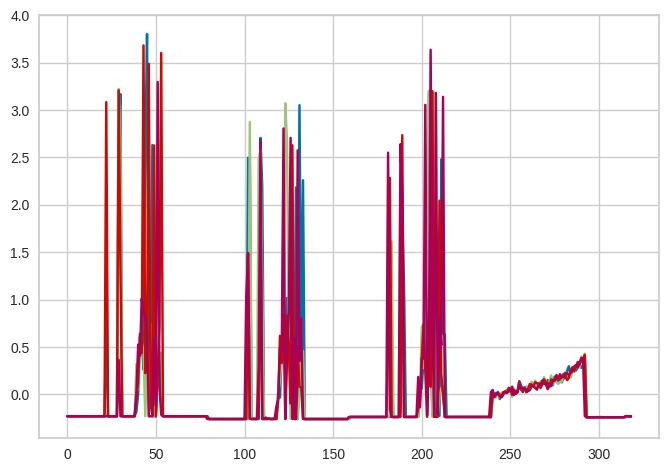

In [169]:
plt.plot(km_nonbots.cluster_centers_.reshape(X_mean_nonbot.shape[1], 4))
plt.show()

In [170]:
unique, counts = np.unique(km_nonbots.labels_, return_counts=True)

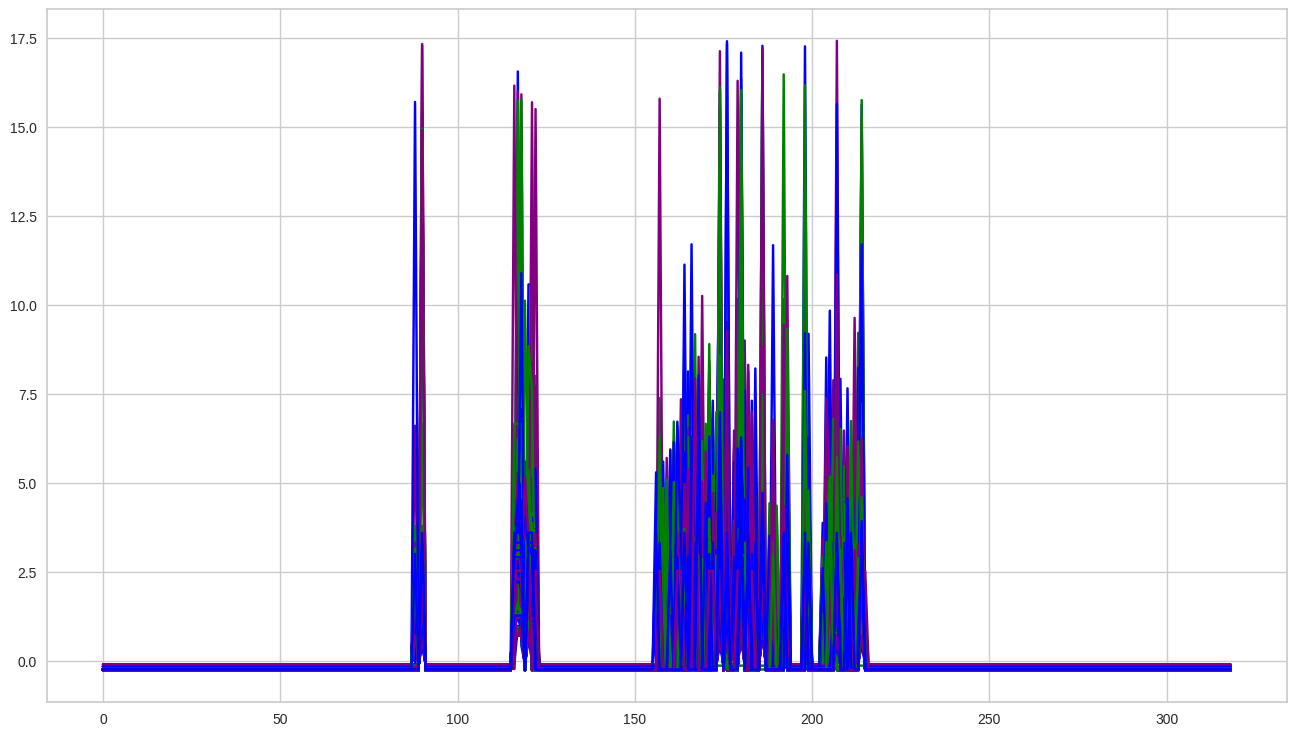

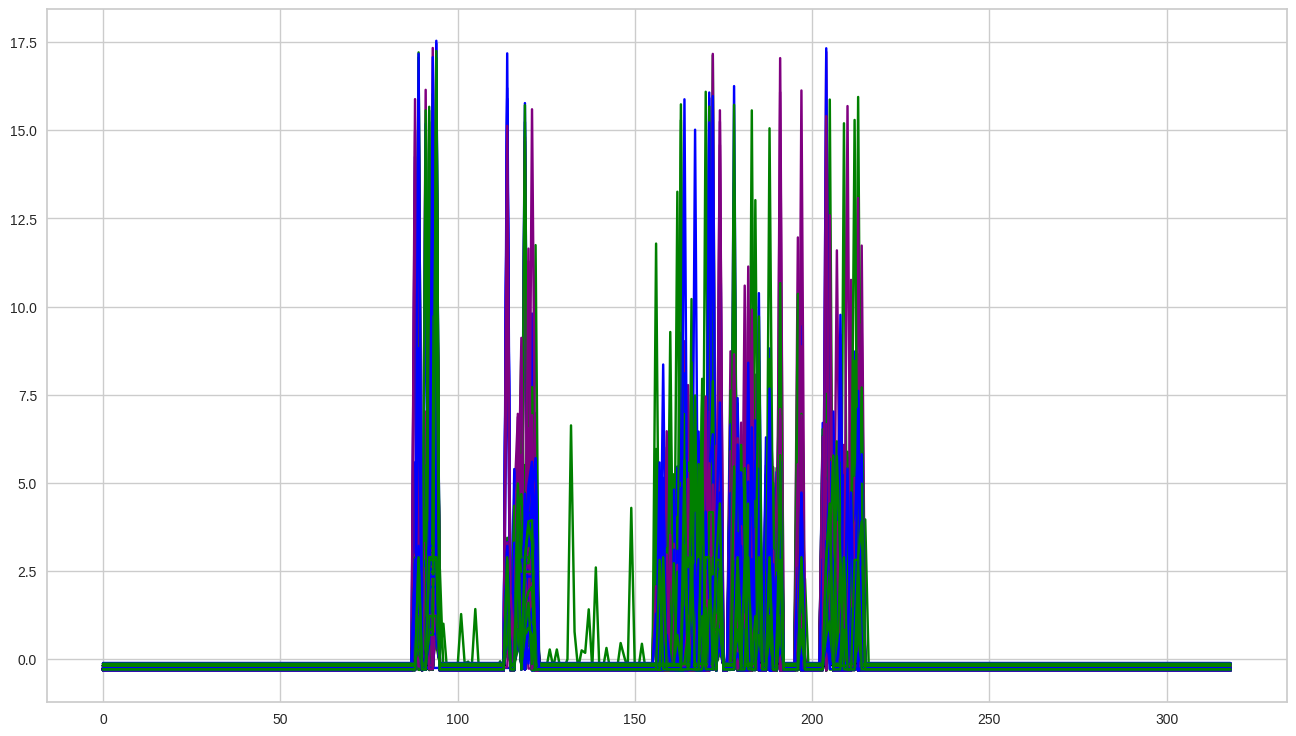

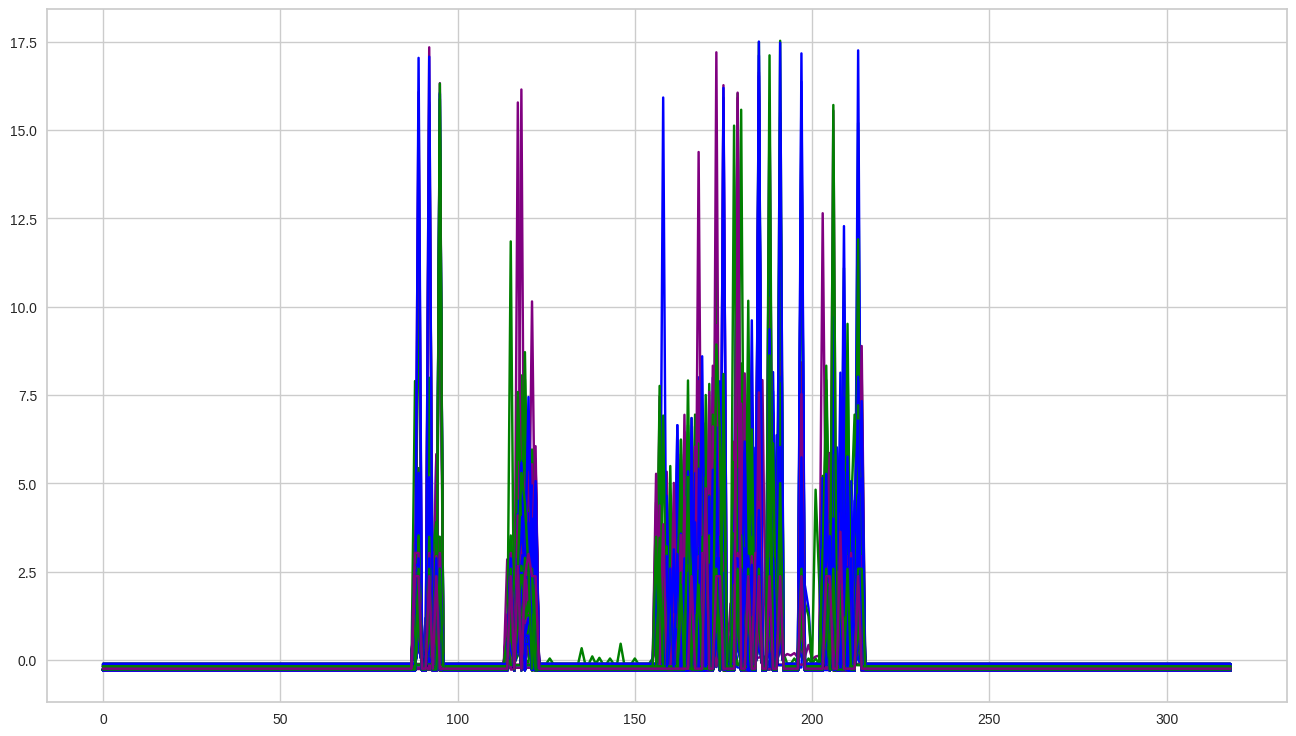

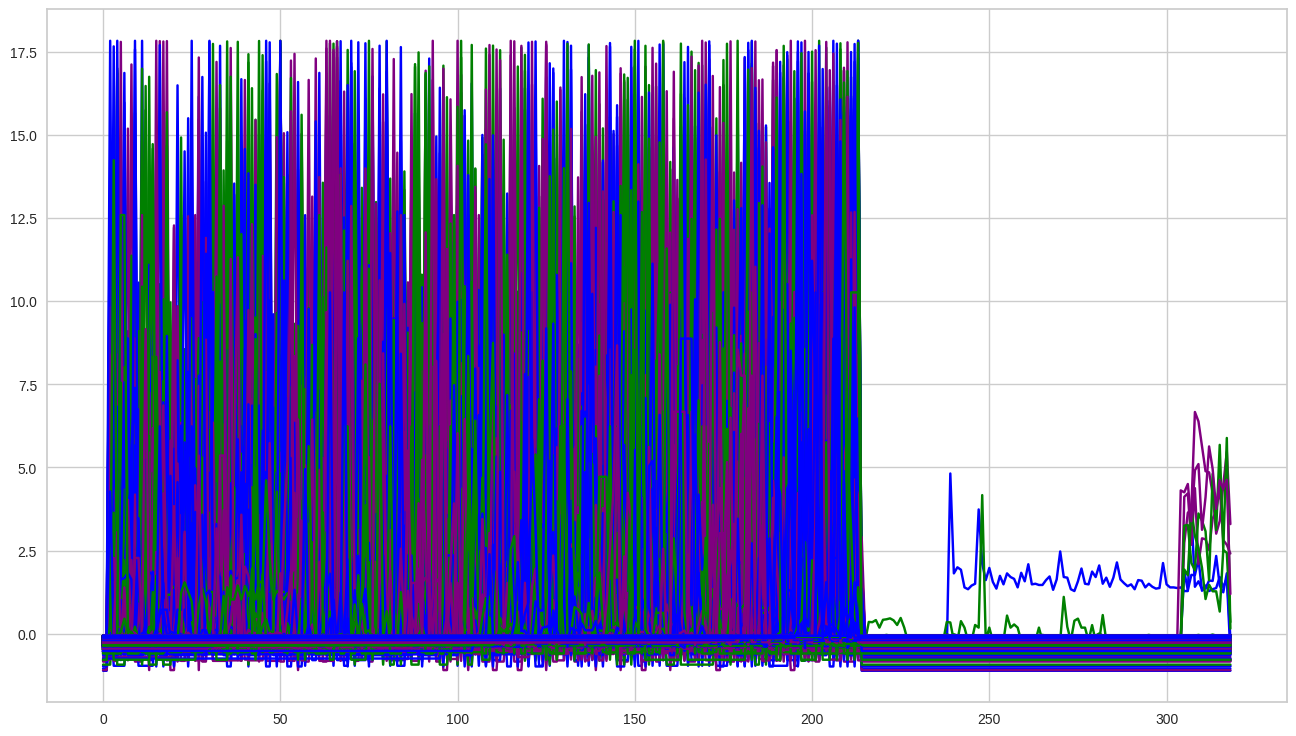

In [171]:
plot_array = []
for j in range(len(counts)):
    t_plot=[]
    for i,elem in enumerate(km_nonbots.labels_):
        if elem == j:
            t_plot.append(X_mean_nonbot[i])

    t_plot = np.array(t_plot)
    plot_array.append(t_plot)
    
for j in range(len(counts)):
    plt.figure(figsize = (16,9))
    for i in range(plot_array[j].shape[0]):
        plt.plot(plot_array[j][i], color=random.choice(pplcol))
    plt.show()

#### Finding K for bots

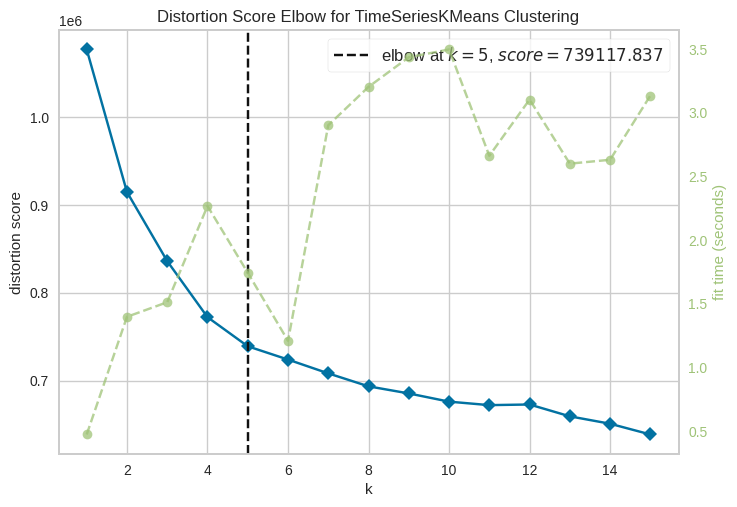

<AxesSubplot: title={'center': 'Distortion Score Elbow for TimeSeriesKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [172]:
visualizer_bot = KElbowVisualizer(model, k=(1,16))
visualizer_bot.fit(X_mean_bot) # Fit the data to the visualizer
visualizer_bot.show()  

#### Clustering bots

In [173]:
km_bots = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=10, random_state=0)
km_bots.fit(X_mean_bot)

TimeSeriesKMeans(max_iter=10, n_clusters=5, random_state=0)

#### Plotting cluster centroids

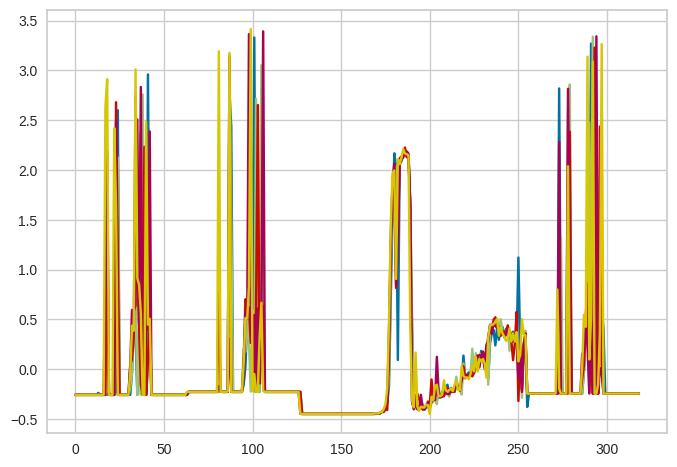

In [174]:
plt.plot(km_bots.cluster_centers_.reshape(X_mean_bot.shape[1], 5))
plt.show()
unique, counts = np.unique(km_bots.labels_, return_counts=True)

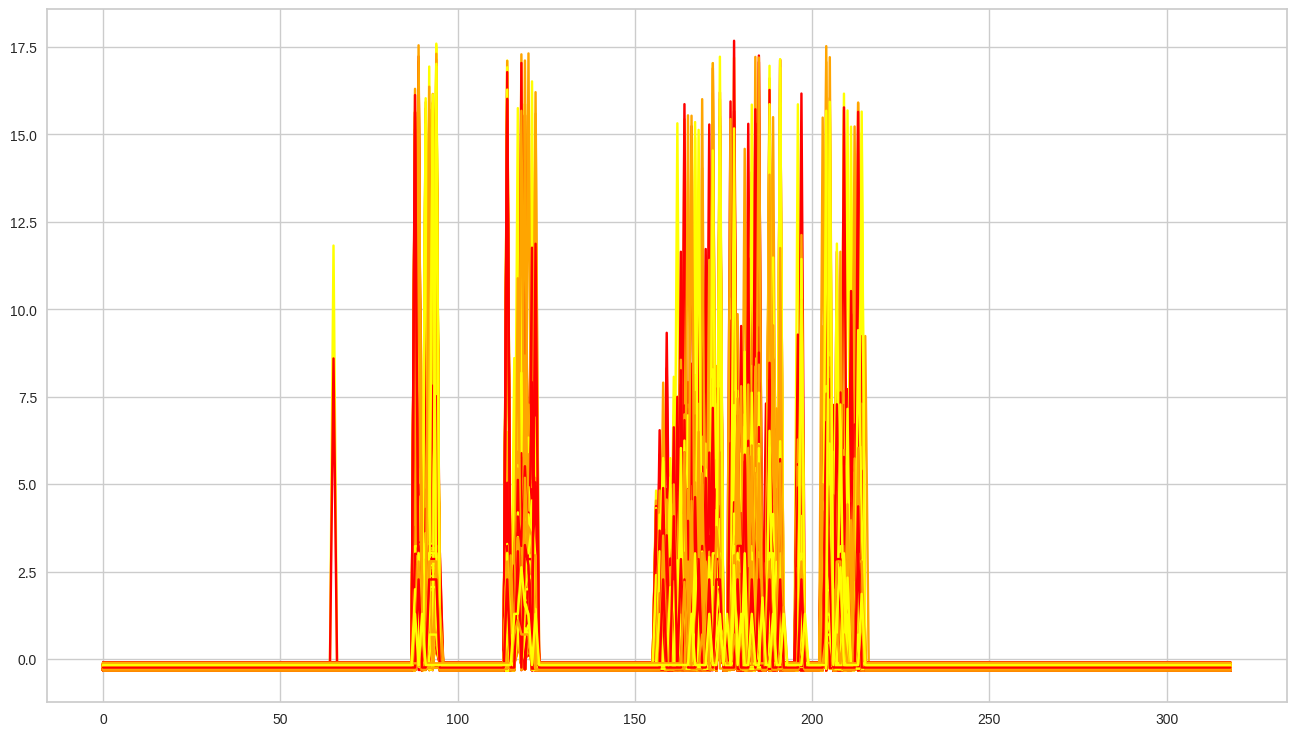

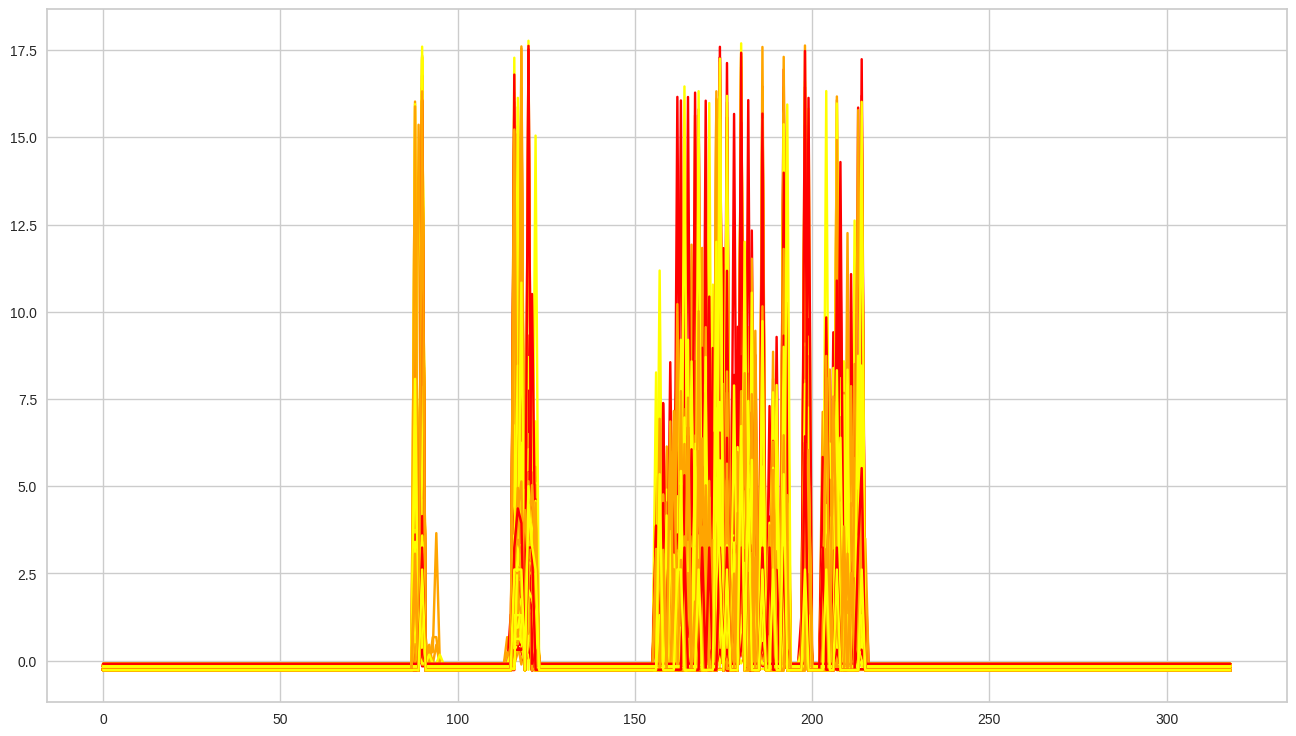

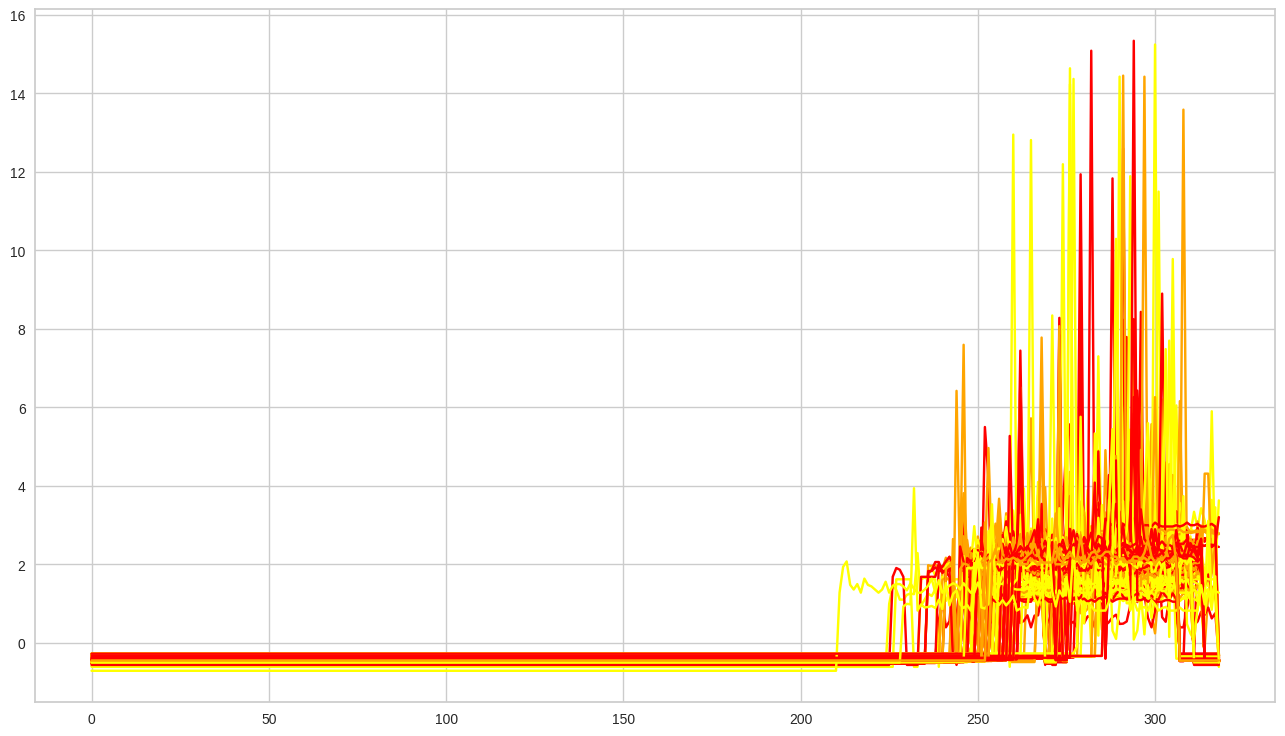

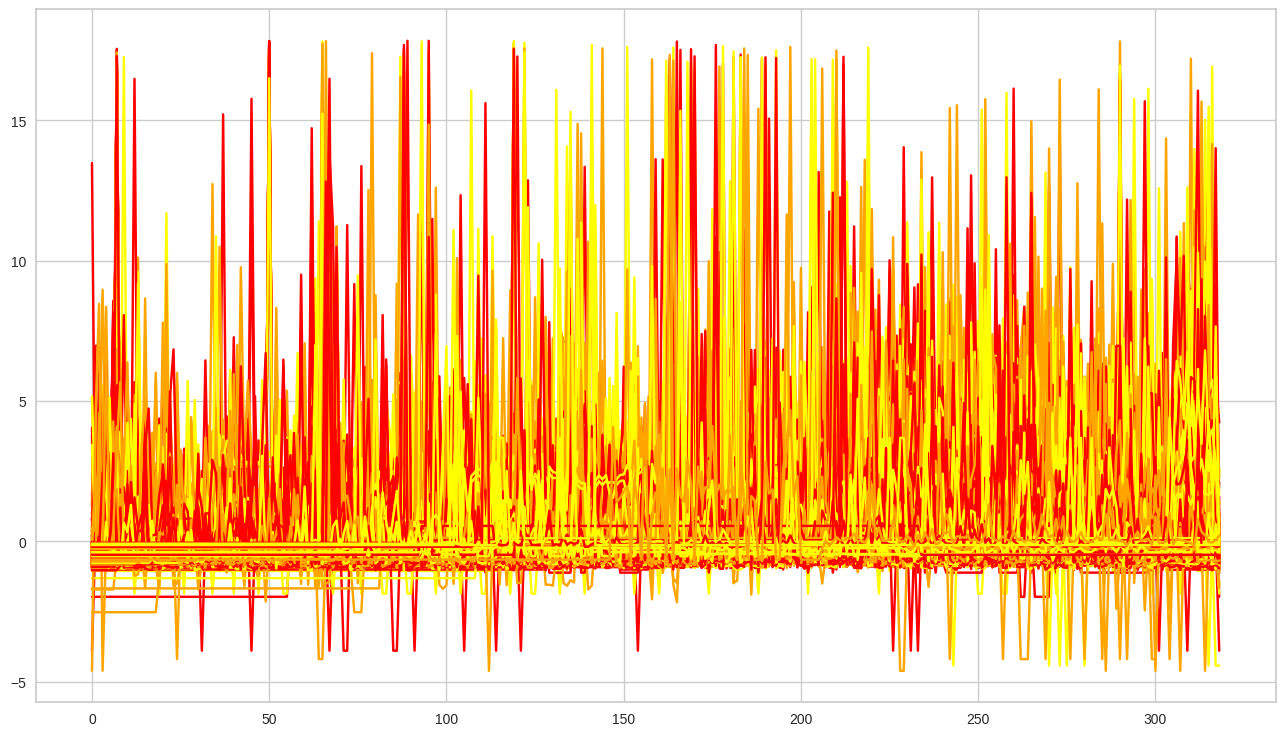

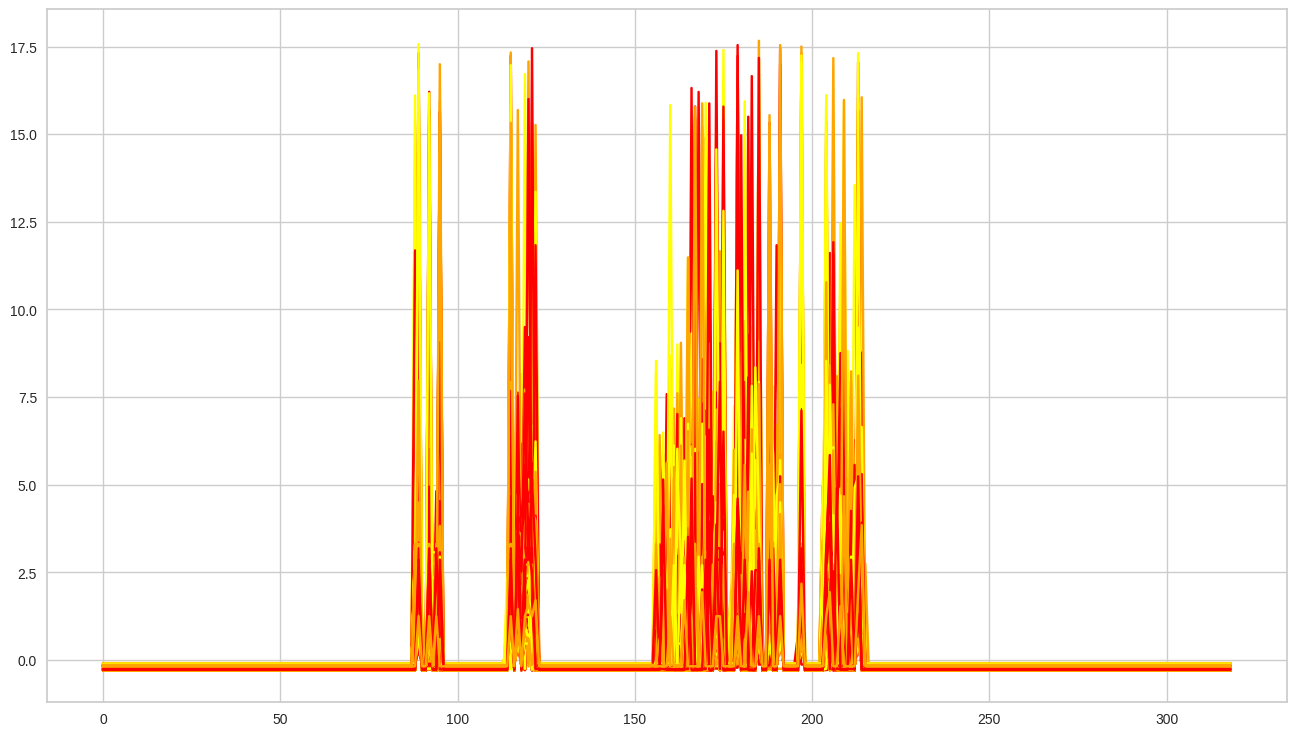

In [175]:
plot_array = []
for j in range(len(counts)):
    t_plot=[]
    for i,elem in enumerate(km_bots.labels_):
        if elem == j:
            t_plot.append(X_mean_bot[i])

    t_plot = np.array(t_plot)
    plot_array.append(t_plot)
    
for j in range(len(counts)):
    plt.figure(figsize = (16,9))
    for i in range(plot_array[j].shape[0]):
        plt.plot(plot_array[j][i], color=random.choice(botcol))
    plt.show()

In [176]:
print(counts)

[1024  660  409 1183  596]
